# P-property check function

In [9]:
# checking if a matrix is p-matrix
import numpy as np
from itertools import combinations
import pandas as pd

def generate_subsets(n):
    # Generate all possible subsets of size 1 to n.
    for size in range(1, n + 1):
        for subset in combinations(range(n), size):
            yield subset
            # print(subset)

def check_p(matrix):
    n = len(matrix)

    # Compute the determinant of the whole matrix first.
    determinant = np.linalg.det(matrix)
    if determinant <= 0:
        return "Not a p-matrix"  # Return immediately if the whole matrix has a non-positive determinant

    # Check the determinants of diagonal elements (smallest subset) next.
    for i in range(n):
        submatrix = matrix[i, i]
        if submatrix <= 0:
            return "Not a p-matrix"  # Return immediately if any diagonal element is non-positive

    # Initialize the generator to get subsets.
    subset_generator = generate_subsets(n)

    # Check the determinants of other subsets.
    for subset in subset_generator:
        if len(subset) > 1:
            submatrix = matrix[np.ix_(subset, subset)]
            determinant = np.linalg.det(submatrix)
            if determinant <= 0:
                return "Not a p-matrix"  # Return immediately if a non-positive determinant is found

    return "All principal minors are positive -> p-matrix"

In [10]:
# Example usage:
matrix = np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9]])
matrix_i = np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]])
result = check_p(matrix)
print('\n')
result_i = check_p(matrix_i)
print(result)
print(result_i)



Not a p-matrix
All principal minors are positive -> p-matrix


- note: for a 25 by 25 matrix it takes about 6 minutes --> no way to do this for 100 by 100 matrix!!

# Calls network

In [11]:
import pandas as pd
import networkx as nx

# Load the dataset
df_ff = pd.read_csv('./ff.csv')
df_tw = pd.read_csv('./tw.csv')

# Drop the 'timestamp' column
df_ff = df_ff.drop(columns=['Kind'])
df_tw = df_tw.drop(columns=['Kind'])

# Display the first few rows of the dataset
print(df_ff.head())
print(df_tw.head())

  source target
0  A6112  A4068
1  A6112  A3006
2  A2153  A1580
3  A1699  A3928
4  A2153  A3363
  source target
0  A5546  A1194
1  A5546  A3817
2  A5546  A2041
3  A1358  A1496
4  A5546  A5589


In [12]:
# Create a directed graph
G_ff = nx.Graph()
G_tw = nx.Graph()

# Add nodes (callers and callees) to the graph
nodes_ff = set(df_ff['source']).union(set(df_ff['target']))
nodes_tw = set(df_tw['source']).union(set(df_tw['target']))

G_ff.add_nodes_from(nodes_ff)
G_tw.add_nodes_from(nodes_tw)

# Add edges with normalized duration as edge weights
for index, row in df_ff.iterrows():
    G_ff.add_edge(row['source'], row['target'])

for index, row in df_tw.iterrows():
    G_tw.add_edge(row['source'], row['target'])

# Display basic graph information
print(nx.info(G_ff))
print(nx.info(G_tw))

Graph with 5540 nodes and 31921 edges
Graph with 5702 nodes and 42327 edges


/var/folders/hs/y116vr4j4yg5fcthw_l99c5r0000gn/T/ipykernel_88738/1846551372.py:20: DeprecationWarning: info is deprecated and will be removed in version 3.0.

  print(nx.info(G_ff))
/var/folders/hs/y116vr4j4yg5fcthw_l99c5r0000gn/T/ipykernel_88738/1846551372.py:21: DeprecationWarning: info is deprecated and will be removed in version 3.0.

  print(nx.info(G_tw))


## Filtering the nodes

In [13]:
# Identify common entities (nodes) across datasets
common_nodes = set(df_ff['source']).intersection(set(df_ff['target']))
common_nodes = common_nodes.intersection(set(df_tw['source']))
common_nodes = common_nodes.intersection(set(df_tw['target']))

# Filter dataframes to keep only common nodes
df_ff_common = df_ff[(df_ff['source'].isin(common_nodes)) & (df_ff['target'].isin(common_nodes))]
df_tw_common = df_tw[(df_tw['source'].isin(common_nodes)) & (df_tw['target'].isin(common_nodes))]

# Display the resulting common dataframes
print("Friendfeed DataFrame (Common Nodes):\n", df_ff_common.head())
print("Twitter DataFrame (Common Nodes):\n", df_tw_common.head())

# Create a graph for common nodes
G_ff_common = nx.Graph()
G_tw_common = nx.Graph()

G_ff_common.add_nodes_from(common_nodes)
G_tw_common.add_nodes_from(common_nodes)

for index, row in df_ff_common.iterrows():
    G_ff_common.add_edge(row['source'], row['target'])

for index, row in df_tw_common.iterrows():
    G_tw_common.add_edge(row['source'], row['target'])

# Display basic graph information
print(nx.info(G_ff_common))
print(nx.info(G_tw_common))

Friendfeed DataFrame (Common Nodes):
    source target
2   A2153  A1580
3   A1699  A3928
4   A2153  A3363
5   A2153  A3798
10  A1398  A4367
Twitter DataFrame (Common Nodes):
    source target
10  A2575  A6387
13  A2575   A952
14  A2575  A1864
15  A1806  A2740
21  A1806  A1635
Graph with 2015 nodes and 17213 edges
Graph with 2015 nodes and 20191 edges


/var/folders/hs/y116vr4j4yg5fcthw_l99c5r0000gn/T/ipykernel_88738/1843344932.py:28: DeprecationWarning: info is deprecated and will be removed in version 3.0.

  print(nx.info(G_ff_common))
/var/folders/hs/y116vr4j4yg5fcthw_l99c5r0000gn/T/ipykernel_88738/1843344932.py:29: DeprecationWarning: info is deprecated and will be removed in version 3.0.

  print(nx.info(G_tw_common))


## Getting the adjacency matrices of common nodes in the multiplex network

In [14]:
# get the adjacency matrix from dataframes
ff_adjacency_matrix = nx.to_numpy_matrix(G_ff_common)
tw_adjacency_matrix = nx.to_numpy_matrix(G_tw_common)

In [22]:
def calculate_attention_matrix(G):
    """
    Calculate the attention matrix for a given binary undirected adjacency matrix.

    Parameters:
    G (numpy.ndarray): A binary undirected adjacency matrix.

    Returns:
    numpy.ndarray: An attention-based adjacency matrix.
    """
    # Ensure the input is a numpy array
    G = np.array(G)
    
    # Calculate the degree (attention) for each agent (row)
    degrees = np.sum(G, axis=1)
    
    eps = 1e-6 

    # Create the attention matrix
    attention_matrix = np.zeros_like(G, dtype=float)
    
    # Fill the attention matrix according to the formula g_{ij} = 1/(agent i degree)
    for i in range(len(G)):
        if degrees[i] > 0:
            attention_matrix[i] = G[i] / degrees[i] - eps
    
    return attention_matrix

# Calculate the attention matrices for the two datasets
ff_attention_matrix = calculate_attention_matrix(ff_adjacency_matrix)
# tw_attention_matrix = calculate_attention_matrix(tw_adjacency_matrix)
tw_attention_matrix = tw_adjacency_matrix/2

## Check p-property for each
checking p-propertty to see if there is a unique nash equilibrium, using I+G

The matrices are too big for our function --> checking the largest connected component in each layer

# Creating the combined multiplex

In [23]:
import random

def bfs_expand(adj_matrix, start_node, max_size):
    """
    Perform BFS to collect up to max_size nodes starting from start_node.
    """
    queue = [start_node]
    visited = set(queue)
    while queue and len(visited) < max_size:
        current = queue.pop(0)
        connected_nodes = np.where(adj_matrix[current] == 1)[0]  # Nodes connected to the current
        for node in connected_nodes:
            if node not in visited:
                visited.add(node)
                queue.append(node)
                if len(visited) == max_size:
                    break
    return list(visited)

def generate_connected_subset(adj_matrix, n, k):
    """
    Generate a subset of k connected nodes starting randomly, potentially restarting if necessary.
    """
    all_nodes = set(range(n))
    collected_nodes = set()
    while len(collected_nodes) < k and all_nodes:
        start_node = random.choice(list(all_nodes))
        new_nodes = bfs_expand(adj_matrix, start_node, k - len(collected_nodes))
        collected_nodes.update(new_nodes)
        all_nodes.difference_update(new_nodes)
    return sorted(list(collected_nodes))

def determinant_of_arbitrary_submatrix(matrix, row_indices, col_indices):
    submatrix = matrix[np.ix_(row_indices, col_indices)]
    det = np.linalg.det(submatrix)
    return det


adj_matrix = ff_adjacency_matrix
# adj_matrix = tw_adjacency_matrix

matrix = np.identity(len(adj_matrix)) + 0.5 * (ff_attention_matrix) + (0.5 * tw_attention_matrix)

n = len(adj_matrix)
k = 30

# Get the subset of connected nodes
subset_indices = generate_connected_subset(adj_matrix, n, k)
# Calculate the determinant for the submatrix
resultant_determinant = determinant_of_arbitrary_submatrix(matrix, subset_indices, subset_indices)
print(resultant_determinant)

0.7466772071937324


In [28]:
import matplotlib.pyplot as plt

n_nodes = 50
iterations = 600

k1_list = []
determinant_list = []

for i in range(iterations):
    if i < 300:
        indices = generate_connected_subset(ff_attention_matrix, len(ff_attention_matrix) - 1, n_nodes)
    else:
        indices = generate_connected_subset(tw_attention_matrix, len(tw_attention_matrix) - 1, n_nodes)

    k1 = np.linspace(0, 1, 50)
    
    determinants = []
    for j in range(len(k1)):
        A = (k1[j] * ff_attention_matrix) + ( (1 - k1[j]) * tw_attention_matrix)
        A = A + np.identity(len(A))
        determinants.append(determinant_of_arbitrary_submatrix(A, indices, indices))
    determinant_list.append(determinants)
    k1_list.append(k1)

print(len(determinant_list))



600


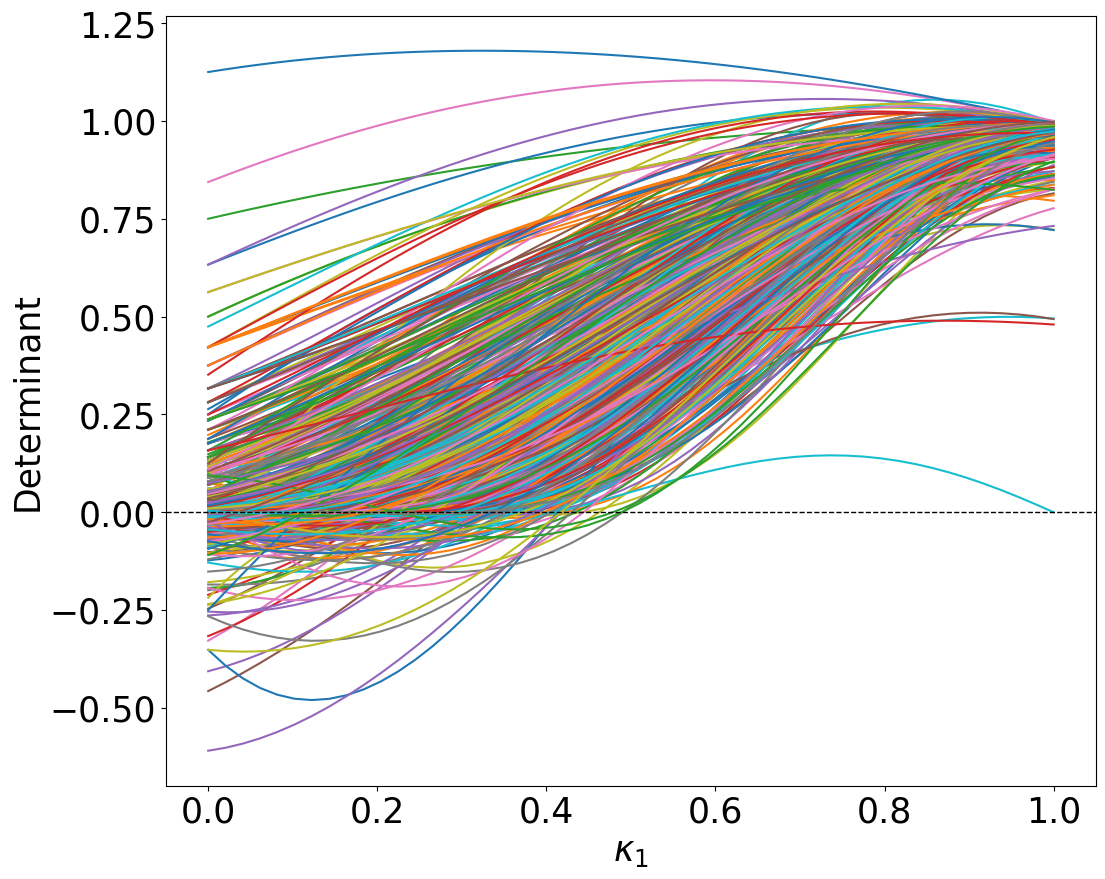

In [29]:
plt.figure(figsize=(12, 10))

for i in range(len(determinant_list)):
    plt.plot(k1_list[i], determinant_list[i])

plt.axhline(0, color='k', linestyle='dashed', linewidth=1)
plt.xlabel('$\kappa_1$')
plt.ylabel('Determinant')
plt.rcParams.update({'font.size': 25})

plt.savefig('determinant_NewData.png', dpi=100)
plt.show()